In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
df = pd.read_csv("../../data/processed_data/case_1.csv")
X = df.drop(columns="class")
y_raw = df["class"]


In [3]:
num_cols = X.select_dtypes(include=["int", "float"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_pipeline = SkPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = SkPipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols),
])


In [4]:
X_proc = preprocessor.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y_raw)

class_weight = dict(enumerate(
    compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
))

X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

input_dim = X_train.shape[1]
num_classes = len(le.classes_)


In [5]:
param_grid = [
    {"layers": [64, 32], "dropout": 0.3, "lr": 1e-3},
    {"layers": [128, 64, 32], "dropout": 0.5, "lr": 5e-4},
    {"layers": [128, 64], "dropout": 0.2, "lr": 1e-3},
]

results = []

for params in param_grid:
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(input_dim,)))

    for units in params["layers"]:
        model.add(tf.keras.layers.Dense(units, activation="relu"))
        if params["dropout"] > 0:
            model.add(tf.keras.layers.Dropout(params["dropout"]))

    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params["lr"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        class_weight=class_weight,
        verbose=0
    )

    val_acc = history.history["val_accuracy"][-1]
    results.append((params, val_acc))
    print(f"Params: {params} → Val acc: {val_acc:.4f}")


Params: {'layers': [64, 32], 'dropout': 0.3, 'lr': 0.001} → Val acc: 0.7488


Params: {'layers': [128, 64, 32], 'dropout': 0.5, 'lr': 0.0005} → Val acc: 0.7311
Params: {'layers': [128, 64], 'dropout': 0.2, 'lr': 0.001} → Val acc: 0.7529


Best params: {'layers': [128, 64], 'dropout': 0.2, 'lr': 0.001}
95/95 [==============================] - 0s 279us/step
              precision    recall  f1-score   support

       fraud       0.69      0.75      0.72      1269
       licit       0.81      0.76      0.78      1767

    accuracy                           0.76      3036
   macro avg       0.75      0.76      0.75      3036
weighted avg       0.76      0.76      0.76      3036



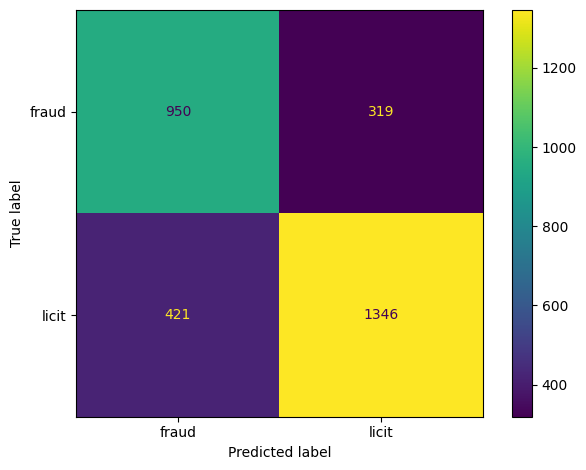

In [6]:
# Choose best based on validation accuracy
best_params = max(results, key=lambda x: x[1])[0]
print("Best params:", best_params)

# Rebuild & retrain on full training set
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(input_dim,)))

for units in best_params["layers"]:
    model.add(tf.keras.layers.Dense(units, activation="relu"))
    if best_params["dropout"] > 0:
        model.add(tf.keras.layers.Dropout(best_params["dropout"]))

model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["lr"]),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    verbose=0
)

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_)
plt.tight_layout()
plt.show()


In [7]:
# ---------------------------------------------------------------------
# 10. Rule Extraction with DEXiRE
# ---------------------------------------------------------------------
import logging, sys
from dexire.dexire import DEXiRE

# 1. Ricava i nomi delle feature
feature_names = preprocessor.get_feature_names_out()

# 2. Ricostruisci il dataframe da dare a DEXiRE
df_train_features = pd.DataFrame(X_train, columns=feature_names)

# 3. Inizializza DEXiRE e genera regole simboliche
dexire = DEXiRE(model=model, class_names=le.classes_.tolist())
rules = dexire.extract_rules(df_train_features, y_train)

# 4. Salva su file o stampa a video
with open("rules.txt", "w", encoding="utf-8") as f:
    f.write(str(rules))

print("✅ Symbolic rules extracted and saved to rules.txt.")


304/304 [==============================] - 0s 262us/step
Unique predictions: [0 1]
304/304 [==============================] - 0s 225us/step
11
feature_11
Symbolic expression: feature_11 <= 0.5
119
feature_119
Symbolic expression: feature_119 <= 0.5
101
feature_101
Symbolic expression: feature_101 <= 0.5
108
feature_108
Symbolic expression: feature_108 <= 0.5
36
feature_36
Symbolic expression: feature_36 <= 0.5
48
feature_48
Symbolic expression: feature_48 <= 0.5
76
feature_76
Symbolic expression: feature_76 <= 0.5
98
feature_98
Symbolic expression: feature_98 <= 0.5
77
feature_77
Symbolic expression: feature_77 <= 0.5
21
feature_21
Symbolic expression: feature_21 <= 0.5
Symbolic expression: feature_21 > 0.5
Symbolic expression: feature_77 > 0.5
Symbolic expression: feature_98 > 0.5
Symbolic expression: feature_76 > 0.5
Symbolic expression: feature_48 > 0.5
Symbolic expression: feature_36 > 0.5
Symbolic expression: feature_108 > 0.5
Symbolic expression: feature_101 > 0.5
121
feature_121

In [8]:
import re

# Mappa indice → nome colonna
idx2name = {i: name for i, name in enumerate(feature_names)}

def prettify(rule_str):
    return re.sub(
        r"X_(\d+)",
        lambda m: idx2name.get(int(m.group(1)), m.group(0)),
        rule_str
    )

# Pulisce e splitta regole in lista
raw = str(rules).strip().lstrip("[").rstrip("]")
raw_list = [r.strip() for r in raw.split(', IF ')]
raw_list = [(r if r.startswith('IF') else 'IF ' + r) for r in raw_list]

# Stampa regole leggibili
pretty_rules = [prettify(r) for r in raw_list]
print("\n📜 Extracted Rules (prettified):\n")
for pr in pretty_rules:
    print(pr)



📜 Extracted Rules (prettified):

IF ((num__unique_out_ratio <= 0.959) AND (num__avg_active_duration <= -0.042) AND (num__total_received <= 0.736) AND (num__net_balance_ratio <= -2.196)) THEN licit
IF ((num__unique_in_ratio <= 0.777) AND (num__total_received <= 0.208) AND (num__unique_in_ratio > -0.983) AND (num__activity_index <= -0.04) AND (num__avg_active_duration <= 0.07) AND (num__net_balance_ratio > -1.977) AND (num__total_received <= -0.119) AND (num__unique_out_ratio <= 0.931) AND (num__in_out_ratio <= -0.024) AND (num__unique_in_ratio > -0.533) AND (num__avg_active_duration <= -0.121) AND (num__total_sent <= 0.375) AND (num__total_out_degree <= 0.242) AND (num__avg_out_time_interval <= 0.089) AND (num__net_balance_ratio > -0.983) AND (num__total_in_degree > 2.852)) THEN fraud
IF ((num__unique_out_ratio <= 0.959) AND (num__avg_active_duration <= -0.042) AND (num__total_received <= 0.736) AND (num__net_balance_ratio > -2.196) AND (num__unique_out_ratio > -1.899) AND (num__unique